# Goals: rebuild Random Forest Classifier from scratch

Use only python and some basic numpy function (numpy slicing, np.mean, np.nonzero)

Produce comparable results to Sklearn Ramdon Forest on some classification dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model.utils import draw_tree
from model.metrics import *
np.random.seed(42)

# Generate a random-generated dataset

In [3]:
nrows=1000
ncols=10
df = pd.DataFrame(np.random.randint(1,10,(nrows,ncols)))
df['y'] = np.random.randint(0,2,(nrows,))
y = df.y.values
df.drop('y',axis=1,inplace=True)

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [5]:
rf = RandomForestClassifier(n_estimators=5,bootstrap=False,min_samples_leaf=3)
rf.fit(df,y)

rf_pred = rf.predict_proba(df)[:,1]
print(f'Log loss score: {logloss(y,rf_pred)}')
print(f'AUC score: {metrics.roc_auc_score(y,rf_pred)}')

Log loss score: 0.24609764270160742
AUC score: 0.9992256902761105


In [6]:
from model.random_forest import RandomForest

In [7]:
tb = RandomForest(df, y, n_trees=5, sample_sz=nrows,is_reg=False)
tb_pred = tb.predict_proba(df)
print(f'Log loss score: {logloss(y,tb_pred)}')
print(f'AUC score: {metrics.roc_auc_score(y,tb_pred)}')

Log loss score: 0.2065798246373121
AUC score: 0.9722128851540617


Results are comparable!

# Benchmarking: Wisconsin Breast Cancer prediction

The Breast Cancer datasets is available machine learning repository maintained by the University of California, Irvine. The dataset contains 569 samples of malignant and benign tumor cells.

- The first two columns in the dataset store the unique ID numbers of the samples and the corresponding diagnosis (M=malignant, B=benign), respectively.
- The columns 3-32 contain 30 real-value features that have been computed from digitized images of the cell nuclei, which can be used to build a model to predict whether a tumor is benign or malignant.

This dataset's missing values are already handled.

In [8]:
data = pd.read_csv("data/cancer.csv")
print(data.shape)
data.head()

(569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
# some preprocessing
target = data['diagnosis'].apply(lambda row: 1 if row=='M' else 0)

data.drop(['id','diagnosis'],axis=1,inplace=True)

In [10]:
from sklearn.model_selection import train_test_split
def get_train_val(X,y):
    X_train,X_val,y_train,y_val =  train_test_split(X, y, test_size=0.15, random_state=42)
    return X_train.reset_index(drop=True),X_val.reset_index(drop=True),y_train,y_val

In [11]:
X_train,X_val,y_train,y_val = get_train_val(data,target)

### sklearn Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators=20,max_depth=4,bootstrap=False,min_samples_leaf=5)
rf.fit(X_train,y_train)

rf_train_pred = rf.predict_proba(X_train)[:,1]
rf_val_pred = rf.predict_proba(X_val)[:,1]

print(f'Log loss train score: {logloss(y_train,rf_train_pred)}')
print(f'Log loss val score: {logloss(y_val,rf_val_pred)}')
print(f'AUC train score: {metrics.roc_auc_score(y_train,rf_train_pred)}')
print(f'AUC val score: {metrics.roc_auc_score(y_val,rf_val_pred)}')

Log loss train score: 0.07286060878119771
Log loss val score: 0.12678704721794842
AUC train score: 0.9974880821415475
AUC val score: 0.9953703703703703


Text(0.5,15,'Predicted label')

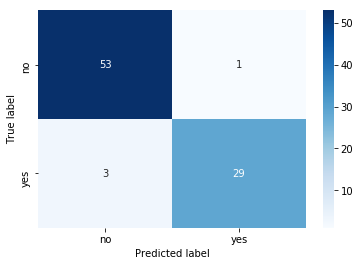

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Compute confusion matrix for a model
cm = confusion_matrix(y_val, rf.predict(X_val))
# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [13]:
%%time
tb = RandomForest(X_train, y_train, n_trees=30, sample_sz=100,min_leaf=5,is_reg=False,max_features=0.9)

Wall time: 9.06 s


In [14]:
tb_train_pred = tb.predict_proba(X_train)
tb_val_pred = tb.predict_proba(X_val)
print(f'Log loss train score: {logloss(y_train,tb_train_pred)}')
print(f'Log loss val score: {logloss(y_val,tb_val_pred)}')
print(f'AUC train score: {metrics.roc_auc_score(y_train,tb_train_pred)}')
print(f'AUC val score: {metrics.roc_auc_score(y_val,tb_val_pred)}')

Log loss train score: 0.12254794731241894
Log loss val score: 0.11123371305066002
AUC train score: 0.9930693069306931
AUC val score: 0.9971064814814815


Los loss and ROC AUC score is a little bit better than Sklearn RF

Text(0.5,15,'Predicted label')

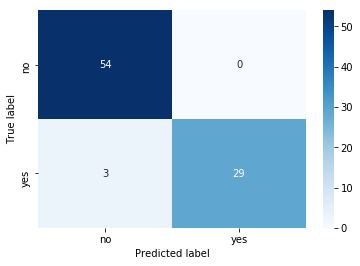

In [19]:
# Compute confusion matrix for a model
cm = confusion_matrix(y_val, tb_val_pred>=0.5)

# view with a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.ylabel('True label')
plt.xlabel('Predicted label')

My RF classifier is able to draw a comparable result to sklearn Random Forest

# Calculate feature importance

Feature importance will be calculated by using **permutation importance**. There is an argument which is mentioned in this [doc](http://parrt.cs.usfca.edu/doc/rf-importance/index.html#3) that feature importance calculated in sklearn is misleading. SKlearn used **mean decrease in impurity (gini improtance)**, which does not always give an accurate picture of importance. 

On the other hand, **permutation importance** is calculated as follows: Record a baseline accuracy (classifier) or R2 score (regressor) by passing a validation set or the out-of-bag (OOB) samples through the Random Forest. Permute the column values of a single predictor feature and then pass all test samples back through the Random Forest and recompute the accuracy or R2. The importance of that feature is the difference between the baseline and the drop in overall accuracy or R2 caused by permuting the column. This is more expensive to calculate, but results are more reliable

In [22]:
from model.utils import permutation_importances

## Feature importance from sklearn RF model

In [20]:
def metric(rf,X_val,y_val):
    y_val_pred = rf.predict_proba(X_val)
    if len(y_val_pred.shape) ==2:
        y_val_pred = y_val_pred[:,1]
    return logloss(y_val,y_val_pred)

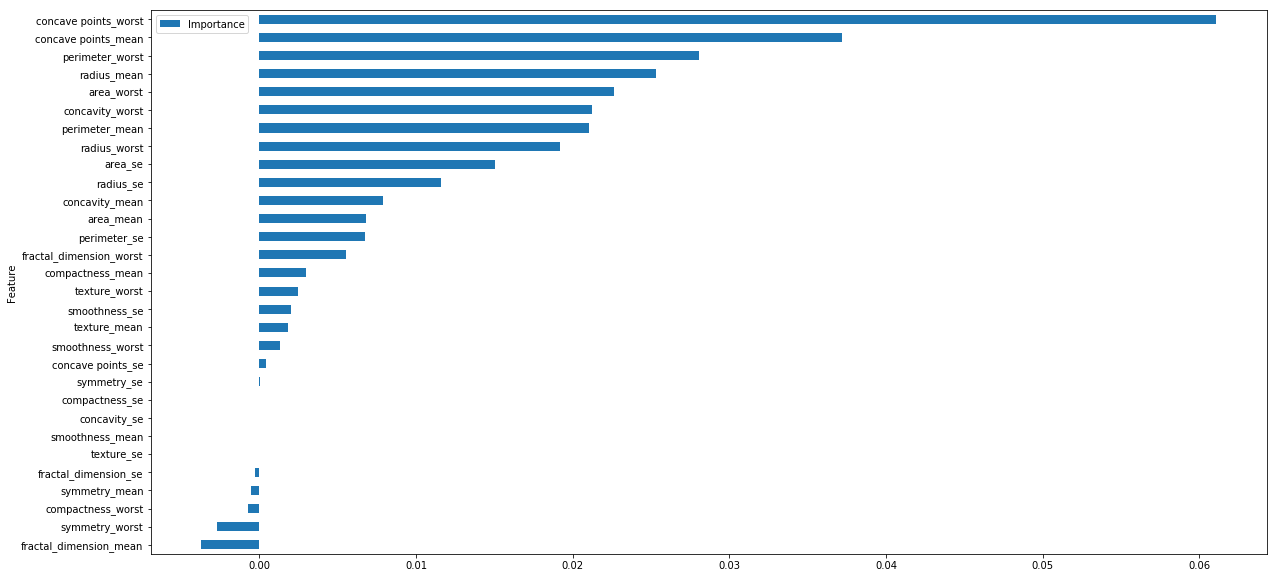

In [23]:
fea_imp_df = permutation_importances(rf,X_val,y_val,metric)

# Feature importance from 'scratch' RF

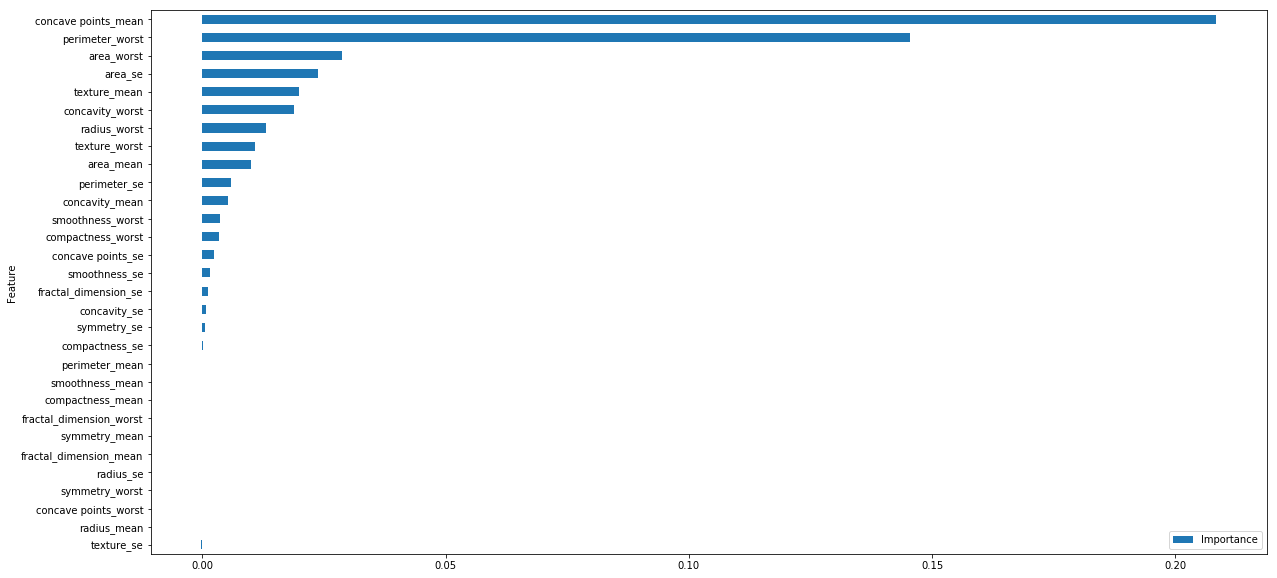

In [24]:
fea_imp_df = permutation_importances(tb,X_val,y_val,metric)

Even with different implementation, my Random Forest classifier is consistent with Sklearn RF in its first 10 important features.